In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 7
commitnumber = f17e0b2
conc = na
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [0]
ng_refs = [7]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 300
w_diffuse = [(2, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8)]
wgt = [(0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

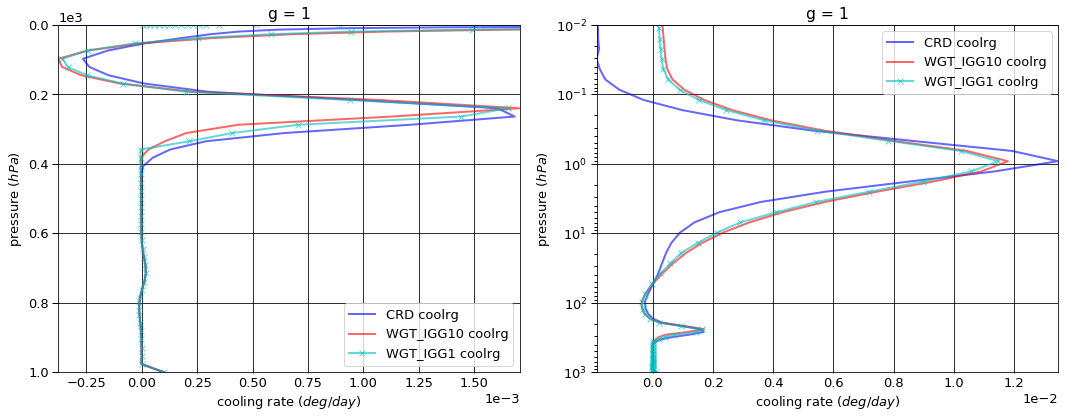

# Figure: cooling rate g-group 2

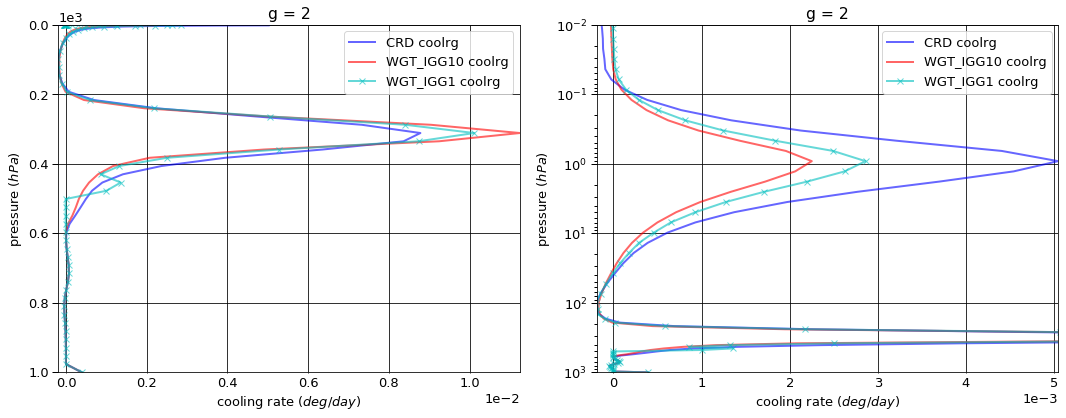

# Figure: cooling rate g-group 3

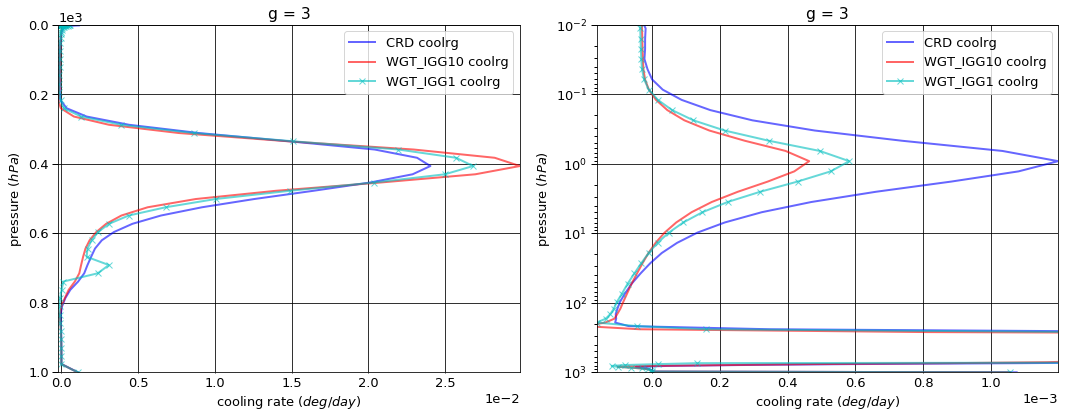

# Figure: cooling rate g-group 4

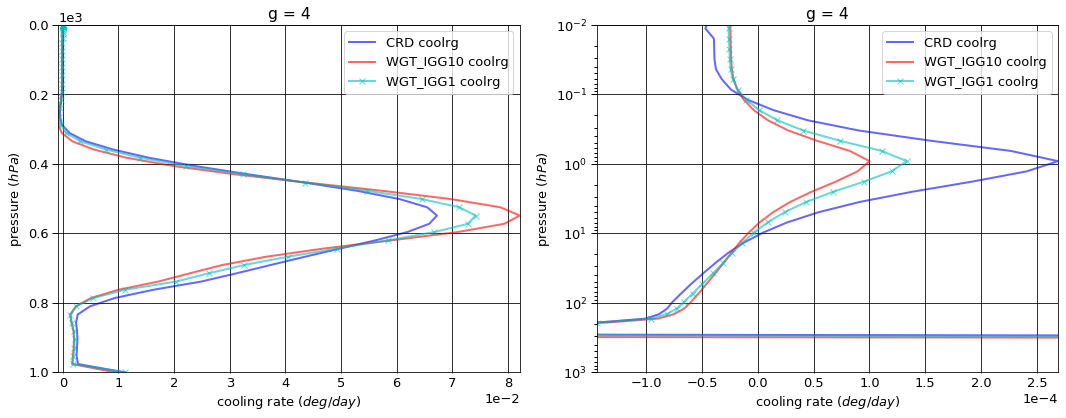

# Figure: cooling rate g-group 5

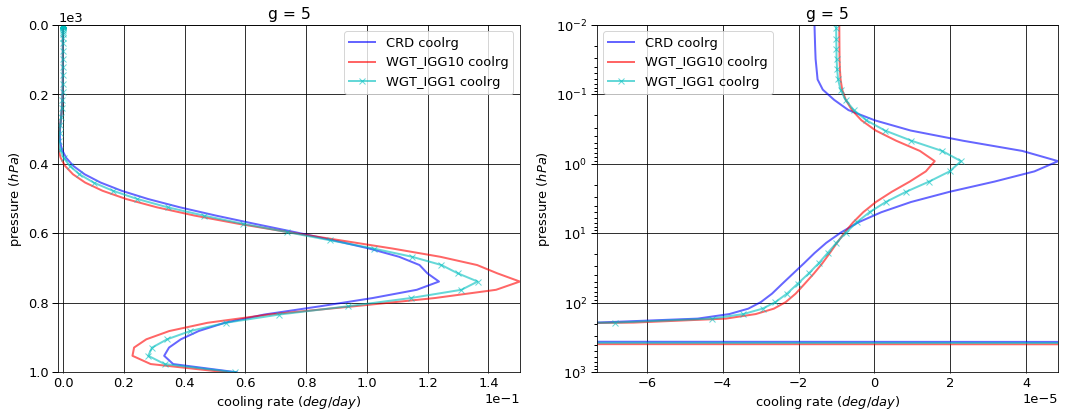

# Figure: cooling rate g-group 6

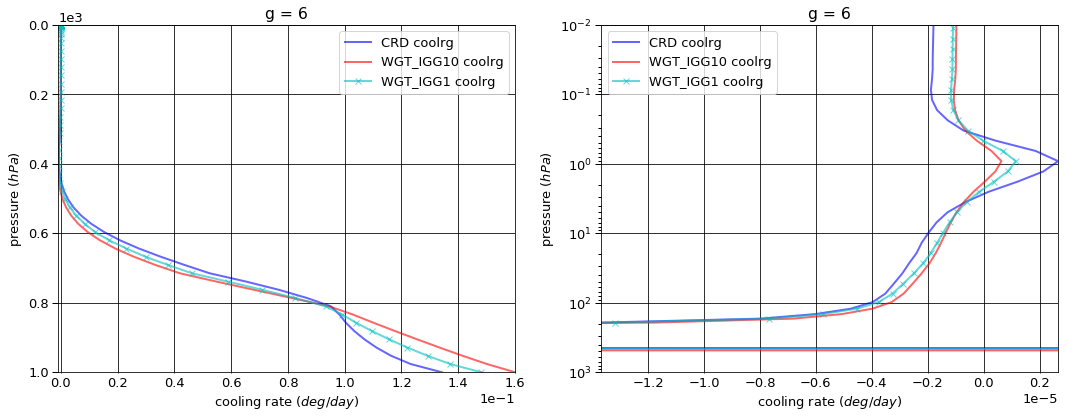

# Figure: cooling rate g-group 7

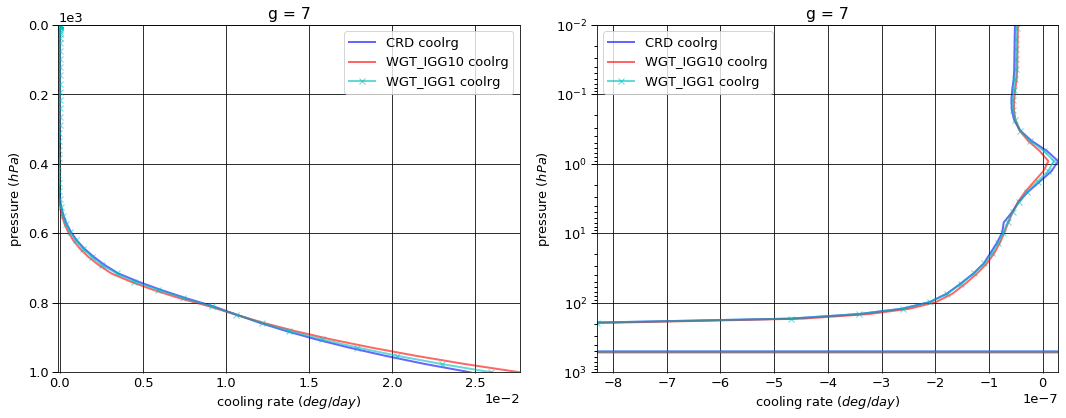

# Figure: cooling rate g-group total

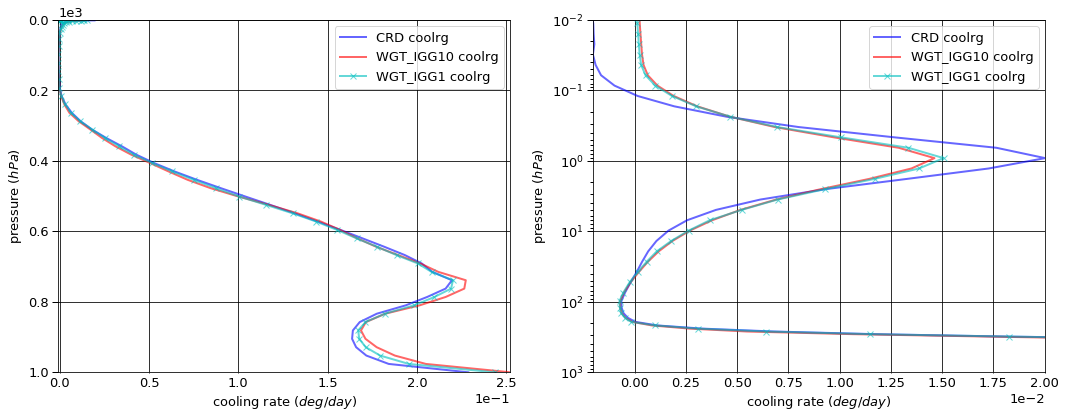

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.023543  0.000000 -0.023543
  1013.0   76    -0.192957  0.192674 -0.000284
2 0.0      1     -0.140950  0.000000 -0.140950
  1013.0   76    -0.756045  0.754949 -0.001097
3 0.0      1     -0.582984  0.000000 -0.582984
  1013.0   76    -2.067309  2.064284 -0.003025
4 0.0      1     -2.297150  0.000000 -2.297150
  1013.0   76    -5.402570  5.372031 -0.030539
5 0.0      1     -4.867491  0.000000 -4.867491
  1013.0   76    -8.000509  7.705087 -0.295421
6 0.0      1     -6.711308  0.000000 -6.711308
  1013.0   76    -8.075941  5.404155 -2.671786
7 0.0      1     -2.349383  0.000000 -2.349383
  1013.0   76    -2.467416  0.608984 -1.858432


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.019937  0.000000 -0.019937
  1013.0   76    -0.192957  0.192674 -0.000284
2 0.0      1     -0.135701  0.000000 -0.135701
  1013.0   76    -0.756045  0.754949 -0.001097
3 0.0      1     -0.570423  0.000000 -0.570423
  1013.0   76    -2.067309  2.064333 -0.002976
4 0.0      1     -2.273074  0.000000 -2.273074
  1013.0   76    -5.402570  5.378353 -0.024217
5 0.0      1     -4.896894  0.000000 -4.896894
  1013.0   76    -8.000509  7.790298 -0.210210
6 0.0      1     -6.832157  0.000000 -6.832157
  1013.0   76    -8.075941  5.439732 -2.636209
7 0.0      1     -2.352535  0.000000 -2.352535
  1013.0   76    -2.467416  0.623916 -1.843500


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.021189  0.000000 -0.021189
  1013.0   76    -0.192957  0.192674 -0.000284
2 0.0      1     -0.135368  0.000000 -0.135368
  1013.0   76    -0.756045  0.754949 -0.001097
3 0.0      1     -0.569986  0.000000 -0.569986
  1013.0   76    -2.067309  2.064333 -0.002976
4 0.0      1     -2.270834  0.000000 -2.270834
  1013.0   76    -5.402570  5.373010 -0.029560
5 0.0      1     -4.879301  0.000000 -4.879301
  1013.0   76    -8.000509  7.769981 -0.230528
6 0.0      1     -6.782719  0.000000 -6.782719
  1013.0   76    -8.075941  5.378721 -2.697220
7 0.0      1     -2.350239  0.000000 -2.350239
  1013.0   76    -2.467416  0.616016 -1.851400


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.003606  0.000000  3.605812e-03
  1013.0   76     0.000000  0.000000  0.000000e+00
2 0.0      1      0.005249  0.000000  5.248670e-03
  1013.0   76     0.000000  0.000000 -2.168404e-19
3 0.0      1      0.012561  0.000000  1.256089e-02
  1013.0   76     0.000000  0.000048  4.830870e-05
4 0.0      1      0.024075  0.000000  2.407530e-02
  1013.0   76     0.000000  0.006322  6.322139e-03
5 0.0      1     -0.029403  0.000000 -2.940320e-02
  1013.0   76     0.000000  0.085211  8.521086e-02
6 0.0      1     -0.120849  0.000000 -1.208490e-01
  1013.0   76     0.000000  0.035577  3.557710e-02
7 0.0      1     -0.003152  0.000000 -3.152000e-03
  1013.0   76     0.000000  0.014931  1.493140e-02


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.002354  0.000000  2.354402e-03
  1013.0   76     0.000000  0.000000  0.000000e+00
2 0.0      1      0.005581  0.000000  5.581150e-03
  1013.0   76     0.000000  0.000000 -2.168404e-19
3 0.0      1      0.012998  0.000000  1.299809e-02
  1013.0   76     0.000000  0.000048  4.830870e-05
4 0.0      1      0.026316  0.000000  2.631620e-02
  1013.0   76     0.000000  0.000979  9.791090e-04
5 0.0      1     -0.011810  0.000000 -1.181000e-02
  1013.0   76     0.000000  0.064894  6.489357e-02
6 0.0      1     -0.071411  0.000000 -7.141150e-02
  1013.0   76     0.000000 -0.025434 -2.543390e-02
7 0.0      1     -0.000856  0.000000 -8.558000e-04
  1013.0   76     0.000000  0.007032  7.032200e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.002204e-03
  1001.112500 75     1.004580e-04
2 0.000312    1     -2.018730e-04
  1001.112500 75     3.886949e-04
3 0.000312    1     -5.133627e-05
  1001.112500 75     1.075706e-03
4 0.000312    1     -4.493482e-05
  1001.112500 75     1.108763e-02
5 0.000312    1     -1.618800e-05
  1001.112500 75     5.719996e-02
6 0.000312    1     -1.704521e-06
  1001.112500 75     1.342646e-01
7 0.000312    1     -4.887318e-08
  1001.112500 75     2.469204e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.232962e-04
  1001.112500 75     1.004580e-04
2 0.000312    1     -5.685192e-05
  1001.112500 75     3.886949e-04
3 0.000312    1     -3.399326e-05
  1001.112500 75     1.055019e-03
4 0.000312    1     -2.635407e-05
  1001.112500 75     9.363788e-03
5 0.000312    1     -9.299401e-06
  1001.112500 75     5.376102e-02
6 0.000312    1     -9.169665e-07
  1001.112500 75     1.600904e-01
7 0.000312    1     -4.349953e-08
  1001.112500 75     2.766905e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      7.553318e-06
  1001.112500 75     1.004580e-04
2 0.000312    1     -4.793998e-05
  1001.112500 75     3.886949e-04
3 0.000312    1     -4.052865e-05
  1001.112500 75     1.055019e-03
4 0.000312    1     -2.848217e-05
  1001.112500 75     1.125772e-02
5 0.000312    1     -1.023069e-05
  1001.112500 75     5.666960e-02
6 0.000312    1     -1.037816e-06
  1001.112500 75     1.481680e-01
7 0.000312    1     -4.586514e-08
  1001.112500 75     2.596400e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.125500e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      1.450211e-04
  1001.112500 75     0.000000e+00
3 0.000312    1      1.734301e-05
  1001.112500 75    -2.068720e-05
4 0.000312    1      1.858075e-05
  1001.112500 75    -1.723838e-03
5 0.000312    1      6.888596e-06
  1001.112500 75    -3.438941e-03
6 0.000312    1      7.875546e-07
  1001.112500 75     2.582578e-02
7 0.000312    1      5.373648e-09
  1001.112500 75     2.977012e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.009758e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      1.539330e-04
  1001.112500 75     0.000000e+00
3 0.000312    1      1.080762e-05
  1001.112500 75    -2.068720e-05
4 0.000312    1      1.645266e-05
  1001.112500 75     1.700940e-04
5 0.000312    1      5.957304e-06
  1001.112500 75    -5.303630e-04
6 0.000312    1      6.667046e-07
  1001.112500 75     1.390346e-02
7 0.000312    1      3.008042e-09
  1001.112500 75     1.271958e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.972808,0.000000,-16.972808
1013.0,76,-26.962746,22.102164,-4.860582



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.080721,0.000000,-17.080721
1013.0,76,-26.962746,22.244254,-4.718493



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.009635,0.000000,-17.009635
1013.0,76,-26.962746,22.149683,-4.813063



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.107914,0.00000,-0.107914
1013.0,76,0.000000,0.14209,0.142090



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.036827,0.000000,-0.036827
1013.0,76,0.000000,0.047519,0.047519


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.002318
1001.112500,75,0.228809



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000004
1001.112500,75,0.252428



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000121
1001.112500,75,0.243604



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002314
1001.112500,75,0.023619



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002198
1001.112500,75,0.014794


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008442,0.006700
2,0.031667,0.026712
3,0.084558,0.073792
4,0.218406,0.193706
5,0.300933,0.294683
6,0.277224,0.307781
7,0.078770,0.096626


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.695655e-20
2,2.527212e-21
3,3.766568e-22
4,5.613710e-23
5,8.366699e-24
6,1.246977e-24
7,1.858499e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.695655e-20,NaN,0.008442,0.006700,0.008442,0.006700,600.0
2,2.527212e-21,0.14904,0.031667,0.026712,0.040109,0.033412,600.0
3,3.766568e-22,0.14904,0.084558,0.073792,0.124667,0.107205,600.0
4,5.613710e-23,0.14904,0.218406,0.193706,0.343073,0.300910,600.0
5,8.366699e-24,0.14904,0.300933,0.294683,0.644006,0.595593,600.0
6,1.246977e-24,0.14904,0.277224,0.307781,0.921230,0.903374,600.0
7,1.858499e-25,0.14904,0.078770,0.096626,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
